In [1]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from keras.models import load_model
import pickle

import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn')

Using TensorFlow backend.


In [2]:
path = '../Entrenamientos/Procesado_Tramos.xlsx'
df = pd.read_excel(path)

In [3]:
#df = df[df["viento_aparente"]!=-np.inf]
df = df[df["porc"]!=np.inf]
#df["puntos_en_tramo"]= df["tramo_final"]-df["tramo_inicial"]
#df = df[df["puntos_en_tramo"]>250]
#df = df[df["porc"]>2]
df = df[df["prueba"]=="20180429_LEMG_195_90_R_C.gpx"]

In [4]:
df.describe()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,60.500000,3496.016393,3547.770492,207.940679,94.262295,726.590164,35.150620,-1.333628,0.058167,49403.237132
std,35.362409,1946.877241,1937.072375,52.063138,172.804471,1130.014691,12.474903,13.483191,2.092644,27074.087892
min,0.000000,0.000000,16.000000,22.992004,1.000000,9.697469,12.922105,-14.992324,-6.597866,173.532309
25%,30.250000,2196.750000,2230.750000,180.272469,7.000000,61.750000,26.661969,-14.375875,-0.870941,30967.492612
50%,60.500000,3286.500000,3353.500000,223.516007,50.500000,466.777042,33.203336,-6.759451,0.003106,47158.500000
75%,90.750000,5248.500000,5283.500000,241.060519,92.750000,847.570583,41.207362,14.235446,0.859900,72401.000000
max,121.000000,6300.000000,6314.000000,299.800000,1158.000000,8788.000000,75.302316,14.918299,7.046886,88630.000000


In [5]:
df.head()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum,prueba
0,0,0,16,196.808012,17,187.41664,39.688230,14.918299,-0.399565,173.532309,20180429_LEMG_195_90_R_C.gpx
1,1,16,75,230.996299,98,886.58336,32.568368,14.577416,0.523132,1055.000000,20180429_LEMG_195_90_R_C.gpx
2,2,75,122,194.043315,60,616.40000,36.984000,14.550887,-0.240187,1677.304307,20180429_LEMG_195_90_R_C.gpx
3,3,122,227,221.693546,193,1692.60000,31.571813,14.552940,0.895103,3364.000000,20180429_LEMG_195_90_R_C.gpx
4,4,227,273,169.324586,47,538.40000,41.239149,14.433466,-1.235191,3911.000000,20180429_LEMG_195_90_R_C.gpx


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   0.,   2.,
          0.,   0.,   1.,   1.,   0.,   3.,   0.,   0.,   1.,   0.,   2.,
          1.,   3.,   1.,   0.,   1.,   4.,   3.,   2.,   1.,   1.,   3.,
          1.,   3.,   3.,  11.,  18.,   8.,   1.,   3.,   3.,   3.,   4.,
          1.,   2.,   1.,   2.,   1.,   0.,   1.,   1.,   2.,   1.,   1.,
          1.,   1.,   1.,   2.,   3.,   2.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([-6.59786614, -6.46141862, -6.32497111, -6.18852359, -6.05207607,
        -5.91562855, -5.77918103, -5.64273351, -5.50628599, -5.36983847,
        -5.23339095, -5.09694343, -4.96049591, -4.82404839, -4.68760087,
        -4.55115335, -4.41470584, -4.27825832, -4.1418108 , -4.00536328,
        -3.86891576, -3.73

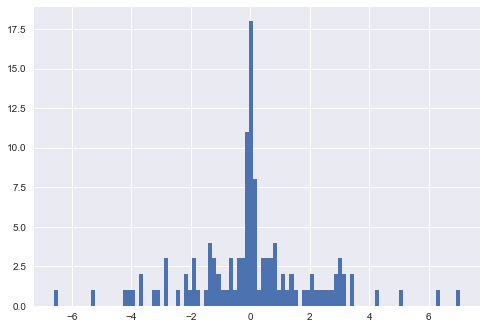

In [6]:
plt.hist(df['porc'],bins=100)

In [22]:
#CON TENSORFLOW
import time
start_time = time.time()

pre_model = joblib.load('../Machine Learning/regr_porc_pwr.model') 

model_TF = load_model('../RNN/TF_Tramos_2.model')
model_Scalar = pickle.load(open("../RNN/Scaler.model", "rb"))



potencia_objetivo = 220
multiplicador_potencia = potencia_objetivo/pre_model.intercept_

resultados = []
fail = 0
exito = 0
num_pruebas = 50
fi = 0


while exito < num_pruebas:
    #print(exito)
    if (fi % 1000) == 0:
        print('Empezamos la prueba %d' %fi)
        print("--- %s seconds ---" % (time.time() - start_time))
    potencia_acum = 0
    tiempo_acum = 0
    i= 0
    lista_tramo_potencia = []
    while i < len(df):
        porc = df[i:i+1]["porc"].iloc[0]
        viento = df[i:i+1]["viento_aparente"].iloc[0]
        distancia = df[i:i+1]["dist"].iloc[0]
        
        #if porc < -2:
        #    potencia = pre_model.predict(porc)[0][0]*multiplicador_potencia+np.random.randint(-abs(porc), abs(porc))
        #elif porc > 2:
        #    #potencia = pre_model.predict(porc)[0][0]+50+np.random.randint(-abs(porc**2), abs(porc**2))
        #    potencia =potencia_objetivo+np.random.randint(0, abs(porc)+50)
        #else:
        #    potencia = potencia_objetivo+np.random.randint(-abs(porc)-10, abs(porc)+30)
        
        #potencia con una sigmoide
        pot_min = 50
        pot_max = 300
        ff_1 = 0.5
        ff_2 = 0.5
        
        potencia = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))+np.random.randint(-10, 10)
        
        
        input_model = model_Scalar.transform([[potencia, porc, viento]])
        
        velocidad = model_TF.predict(input_model)[0]
        
        nuevo_tiempo = distancia/(velocidad/3.6)
        lista_tramo_potencia.append([i, potencia,velocidad[0],distancia,nuevo_tiempo[0],porc,viento])
        
        potencia_acum = potencia_acum + (potencia * nuevo_tiempo)
        tiempo_acum = tiempo_acum + nuevo_tiempo
        
        i += 1
    potencia_media = potencia_acum/tiempo_acum
    print("Intento %d con potencia media %d" %(fi, potencia_media))
    
    if (potencia_media > potencia_objetivo-20) and (potencia_media < potencia_objetivo+20):
        #print(potencia_media, tiempo_acum)
        resultados.append([fi,potencia_media[0], tiempo_acum[0], lista_tramo_potencia])
        exito +=1
    else:
        fail +=1
    
    fi +=1

print("---Total time: %s seconds ---" % (time.time() - start_time))

print('Casos descartados: %d' %fail)
print('Casos de favorables: %d' %(len(resultados)))

Empezamos la prueba 0
--- 1.09434175491333 seconds ---
Intento 0 con potencia media 225
Intento 1 con potencia media 222
Intento 2 con potencia media 221
Intento 3 con potencia media 223
Intento 4 con potencia media 222
Intento 5 con potencia media 224
Intento 6 con potencia media 223
Intento 7 con potencia media 224
Intento 8 con potencia media 222
Intento 9 con potencia media 223
Intento 10 con potencia media 224
Intento 11 con potencia media 223
Intento 12 con potencia media 223
Intento 13 con potencia media 223
Intento 14 con potencia media 223
Intento 15 con potencia media 222
Intento 16 con potencia media 222
Intento 17 con potencia media 224
Intento 18 con potencia media 223
Intento 19 con potencia media 222
Intento 20 con potencia media 221
Intento 21 con potencia media 223
Intento 22 con potencia media 223
Intento 23 con potencia media 222
Intento 24 con potencia media 223
Intento 25 con potencia media 222
Intento 26 con potencia media 224
Intento 27 con potencia media 222
Int

In [25]:
ds = pd.DataFrame(resultados)
ds.columns = ('intento','pwr','secs','list')
ds

,intento,pwr,secs,list
0,0,225.152206,10589.503906,"[[0, 195.22470073, 37.003, 187.41664, 18.2337,..."
1,1,222.605576,10701.290039,"[[0, 202.22470073, 37.2785, 187.41664, 18.0989..."
2,2,221.930847,10729.333984,"[[0, 205.22470073, 37.3965, 187.41664, 18.0418..."
3,3,223.043106,10666.888672,"[[0, 214.22470073, 37.7508, 187.41664, 17.8725..."
4,4,222.483444,10657.084961,"[[0, 197.22470073, 37.0817, 187.41664, 18.195,..."
5,5,224.040543,10629.527344,"[[0, 211.22470073, 37.6327, 187.41664, 17.9286..."
6,6,223.387466,10634.900391,"[[0, 195.22470073, 37.003, 187.41664, 18.2337,..."
7,7,224.683517,10663.506836,"[[0, 203.22470073, 37.3178, 187.41664, 18.0798..."
8,8,222.870453,10663.606445,"[[0, 214.22470073, 37.7508, 187.41664, 17.8725..."
9,9,223.192459,10617.724609,"[[0, 201.22470073, 37.2391, 187.41664, 18.118,..."


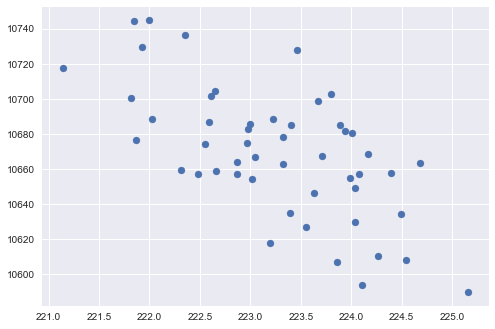

In [26]:
plt.scatter(ds['pwr'],ds['secs'])

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  2.,  0.,  0.,
         0.,  1.,  1.,  1.,  1.,  4.,  0.,  0.,  2.,  2.,  3.,  0.,  2.,
         0.,  3.,  2.,  0.,  2.,  2.,  0.,  2.,  2.,  2.,  4.,  1.,  1.,
         0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([ 221.14741516,  221.22751099,  221.30760681,  221.38770264,
         221.46779846,  221.54789429,  221.62799011,  221.70808594,
         221.78818176,  221.86827759,  221.94837341,  222.02846924,
         222.10856506,  222.18866089,  222.26875671,  222.34885254,
         222.42894836,  222.50904419,  222.58914001,  222.66923584,
         222.74933167,  222.82942749,  222.90952332,  222.98961914,
         223.06971497,  223.14981079,  223.22990662,  223.31000244,
         223.39009827,  223.47019409,  223.55028992,  223.63038574,
         223.71048157,  223.79057739,  223.87067322,  223.95076904,
         224.03086487,  224.11096069,  224.19105652,  224.27115234,
         224.35124817,  224.43134399

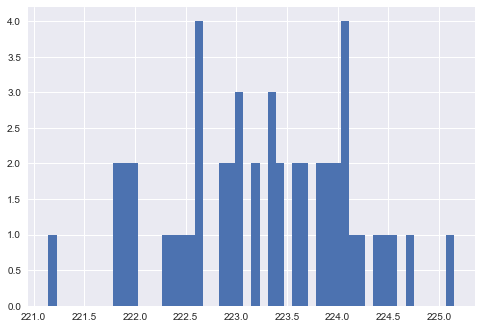

In [27]:
plt.hist(ds['pwr'],bins=50)

In [66]:
a = ds.groupby(['intento'])['secs'].agg('sum').sort_values(ascending=True)
a[:1].max()

10589.50390625

In [84]:
ganadores = pd.DataFrame(ds[ds['secs']<=a[:2].max()]['list'])
ganadores

,list
0,"[[0, 195.22470073, 37.003, 187.41664, 18.2337,..."
39,"[[0, 205.22470073, 37.3965, 187.41664, 18.0418..."


In [88]:
df_ganador = pd.DataFrame(ganadores.values[0][0])
#df_ganador.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
#df_ganador.to_excel('res_sim.xls')
df_ganador

,0,1,2,3,4,5,6
0,0,195.224701,37.002964,187.416640,18.233671,-0.399565,14.918299
1,1,230.515508,34.558563,886.583360,92.356277,0.523132,14.577416
2,2,202.866869,36.587818,616.400000,60.649693,-0.240187,14.550887
3,3,245.451984,33.575493,1692.600000,181.482376,0.895103,14.552940
4,4,176.719745,39.502613,538.400000,49.066124,-1.235191,14.433466
5,5,230.496112,35.968987,19.266672,1.928328,0.176531,14.426397
6,6,202.121268,36.641254,40.449306,3.974141,-0.266013,14.457993
7,7,239.546603,34.017399,640.884022,67.823601,0.728433,14.370793
8,8,206.174433,37.145317,139.000000,13.471416,-0.367222,14.186360
9,9,284.772480,22.828733,1170.000000,184.504318,3.473797,14.525184
